In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Largely copied/following along https://github.com/kstoreyf/gaia-quasars-lss/blob/main/code/selection_function_map.py !

#### GOAL: Make selection function maps (not including the dipole!) with a Gaussian process

In [2]:
import numpy as np
import time

from scipy.optimize import minimize
import healpy as hp
from healpy.newvisufunc import projview
import george

from astropy.table import Table
import os

#### Start with just star map:

In [3]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G_max = 20.5

In [4]:
# load data
cat_dir = f'/scratch/aew492/quasars/catalogs'
fn_gaia = f'catalog_G{G_max}.fits'
tab_gaia = Table.read(os.path.join(cat_dir, fn_gaia))

In [5]:
# qso positions
pixel_indices = hp.ang2pix(NSIDE, tab_gaia['ra'], tab_gaia['dec'], lonlat=True)
map_nqso_data = np.bincount(pixel_indices, minlength=NPIX)

In [6]:
# load star map
star_fn = f'map_stars_NSIDE{NSIDE}.npy'
starmap = np.load(os.path.join(cat_dir, star_fn))

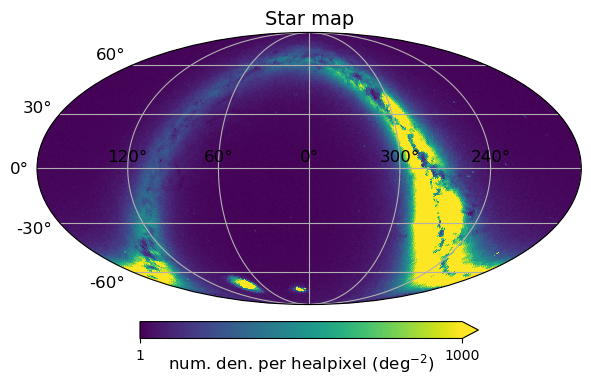

In [7]:
# check it out
projview(starmap, title='Star map', projection_type='mollweide', width=6,
            unit=r"num. den. per healpixel (deg$^{-2}$)", coord=['C'], max=1e3,
            graticule=True, graticule_labels=True)

#### constructing X and y

In [8]:
# construct X (modified from this function in Kate's script): the maps
# subsample: take every 100th value
X_train_full = np.log(starmap)[0::100]
# construct y: the quasar data
# subsample: take every 100th value
y_train_full = map_nqso_data[0::100]
y_train_full = y_train_full.astype(float)  # need this because will be inserting small vals where zero
# assume Poisson error
y_err_train_full = np.sqrt(y_train_full)

In [9]:
X_train_full.shape, y_train_full.shape, y_err_train_full.shape

((492,), (492,), (492,))

In [10]:
# only fit non-zero values (fit_zeros=False)
idx_fit = y_train_full > 0
X_train = X_train_full[idx_fit]
y_train = y_train_full[idx_fit]
y_err_train = y_err_train_full[idx_fit]
print(np.min(y_train))

1.0


### train Fitter !

In [11]:
# scale X -> zero mean
X_train_scaled = X_train.copy()
X_train_scaled -= np.mean(X_train_scaled, axis=0)

In [12]:
np.mean(X_train_scaled)

-4.945773102738516e-17

In [13]:
# scale y -> log
y_train_scaled = y_train.copy()
y_train_scaled = np.log(y_train_scaled)

In [14]:
# scale y err -> log
y_err_train_scaled = y_err_train / y_train

In [15]:
ndim = 1
n_params = 1

In [16]:
# initial parameters
p0 = np.exp(np.full(n_params, 0.1))

In [17]:
# choose a kernel (covariance) function: ExpSquared
kernel = george.kernels.ExpSquaredKernel(p0, ndim=ndim)

In [18]:
# initialize GP (and assume zero mean)
gp = george.GP(kernel)

In [19]:
print('p init:', gp.get_parameter_vector())

p init: [0.1]


In [20]:
# compute(): Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
gp.compute(X_train_scaled, y_err_train_scaled)

In [21]:
print('p compute:', gp.get_parameter_vector())

p compute: [0.1]


In [22]:
print('lnlike compute:', gp.log_likelihood(y_train_scaled))

lnlike compute: -319.54524126949553


#### functions

In [23]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y_train_scaled)

In [24]:
def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y_train_scaled)

#### maximize the likelihood

In [25]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)

In [26]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 314.6741061836262
        x: [ 9.175e-01]
      nit: 5
      jac: [ 7.935e-06]
 hess_inv: [[ 6.662e-02]]
     nfev: 7
     njev: 7

In [27]:
# set parameter vector to the params that maximize ln like
gp.set_parameter_vector(result.x)

In [28]:
print('p post op:', gp.get_parameter_vector())
print('lnlike final:', gp.log_likelihood(y_train_scaled))

p post op: [0.91752688]
lnlike final: -314.6741061836262


#### predict

In [29]:
# use scaled X train
print('predict p:', gp.get_parameter_vector())
y_pred_scaled, _ = gp.predict(y_train_scaled, X_train_scaled)

predict p: [0.91752688]


In [30]:
# unscale y
y_unscaled = np.exp(y_pred_scaled)

In [31]:
y_unscaled.shape

(431,)